In [ ]:

# Movie Recommender System Project
# Using NumPy & Pandas
# User-Based and Item-Based Collaborative Filtering


import pandas as pd
import numpy as np
import os
import zipfile
import requests


# Step 1: Download and Load Dataset

dataset_url = "http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
zip_file = "ml-latest-small.zip"
dataset_folder = "ml-latest-small"

# Download dataset if not present
if not os.path.exists(zip_file):
    print("Downloading MovieLens dataset...")
    r = requests.get(dataset_url)
    with open(zip_file, "wb") as f:
        f.write(r.content)
    print("Download complete.")

# Extract dataset if not already extracted
if not os.path.exists(dataset_folder):
    print("Extracting dataset...")
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(".")
    print("Extraction complete.")

# Load movies and ratings data
movies = pd.read_csv(os.path.join(dataset_folder, "movies.csv"))  # movieId, title, genres
ratings = pd.read_csv(os.path.join(dataset_folder, "ratings.csv"))  # userId, movieId, rating, timestamp

print(f"Movies dataset shape: {movies.shape}")
print(f"Ratings dataset shape: {ratings.shape}")


# Step 2: Create User-Item Matrix

# Rows = users, Columns = movies, Values = ratings
user_movie_matrix = ratings.pivot_table(index='userId', columns='movieId', values='rating').fillna(0)

# Convert to NumPy array for faster computation
user_movie_matrix_np = user_movie_matrix.values
user_ids = user_movie_matrix.index
movie_ids = user_movie_matrix.columns

print(f"User-Movie matrix shape: {user_movie_matrix.shape}")


# Step 3: Compute Cosine Similarity

def cosine_similarity_matrix(matrix):
    """
    Compute cosine similarity between rows of a matrix
    """
    norm = np.linalg.norm(matrix, axis=1, keepdims=True)
    norm_matrix = matrix / np.where(norm==0, 1, norm)  # Avoid division by zero
    similarity = np.dot(norm_matrix, norm_matrix.T)
    return similarity

# User similarity (for user-based CF)
user_similarity = cosine_similarity_matrix(user_movie_matrix_np)

# Item similarity (for item-based CF)
item_similarity = cosine_similarity_matrix(user_movie_matrix_np.T)


# Step 4: User-Based Collaborative Filtering

def recommend_movies_user_based(user_id, num_recommendations=5):
    """
    Recommend movies for a user using User-Based Collaborative Filtering
    """
    user_idx = np.where(user_ids == user_id)[0][0]
    similarities = user_similarity[user_idx]  # similarity of user_id to all users
    
    # Weighted sum of ratings
    weighted_ratings = similarities.dot(user_movie_matrix_np)
    # Normalize by sum of similarities
    weighted_ratings /= similarities.sum()
    
    # Exclude already rated movies
    rated_movies = user_movie_matrix_np[user_idx] > 0
    weighted_ratings[rated_movies] = -1  # mark already rated movies
    
    # Top N recommended movie indices
    top_movie_indices = np.argsort(weighted_ratings)[::-1][:num_recommendations]
    recommended_movie_ids = movie_ids[top_movie_indices]
    recommended_titles = movies[movies['movieId'].isin(recommended_movie_ids)]['title'].values
    
    return recommended_titles


# Step 5: Item-Based Collaborative Filtering

def recommend_movies_item_based(user_id, num_recommendations=5):
    """
    Recommend movies for a user using Item-Based Collaborative Filtering
    """
    user_idx = np.where(user_ids == user_id)[0][0]
    user_ratings = user_movie_matrix_np[user_idx]
    
    # Predict ratings: weighted sum of item similarities
    scores = item_similarity.dot(user_ratings)
    # Normalize by sum of similarities for each item
    scores /= item_similarity.sum(axis=1)
    
    # Exclude already rated movies
    scores[user_ratings > 0] = -1
    
    # Top N recommended movie indices
    top_movie_indices = np.argsort(scores)[::-1][:num_recommendations]
    recommended_movie_ids = movie_ids[top_movie_indices]
    recommended_titles = movies[movies['movieId'].isin(recommended_movie_ids)]['title'].values
    
    return recommended_titles


# Step 6: Example Recommendations

user_to_test = 1
print(f"User-Based Recommendations for User {user_to_test}:")
print(recommend_movies_user_based(user_to_test))

print(f"\nItem-Based Recommendations for User {user_to_test}:")
print(recommend_movies_item_based(user_to_test))

Movies dataset shape: (9742, 3)
Ratings dataset shape: (100836, 4)
User-Movie matrix shape: (610, 9724)
User-Based Recommendations for User 1:
['Shawshank Redemption, The (1994)' 'Terminator 2: Judgment Day (1991)'
 'Godfather, The (1972)' 'Sixth Sense, The (1999)'
 'Lord of the Rings: The Fellowship of the Ring, The (2001)']

Item-Based Recommendations for User 1:
['Inkwell, The (1994)' 'Supercop 2 (Project S) (Chao ji ji hua) (1993)'
 'In Too Deep (1999)' 'Venom (1982)' 'Righteous Kill (2008)']


In [ ]:

# Data Preprocessing: Create clean dataframe

# Merge ratings with movie titles
ratings_with_titles = ratings.merge(movies[['movieId', 'title']], on='movieId')

# Keep only necessary columns
ratings_df = ratings_with_titles[['userId', 'movieId', 'title', 'rating']]

# Display the first few rows
print("Preprocessed Ratings DataFrame:")
print(ratings_df.head())

Preprocessed Ratings DataFrame:
   userId  movieId                        title  rating
0       1        1             Toy Story (1995)     4.0
1       1        3      Grumpier Old Men (1995)     4.0
2       1        6                  Heat (1995)     4.0
3       1       47  Seven (a.k.a. Se7en) (1995)     5.0
4       1       50   Usual Suspects, The (1995)     5.0


Top 5 movies by average rating (50+ ratings):
                                                  title  average_rating  \
7593                   Shawshank Redemption, The (1994)        4.429022   
3499                              Godfather, The (1972)        4.289062   
3011                                  Fight Club (1999)        4.272936   
1961                              Cool Hand Luke (1967)        4.271930   
2531  Dr. Strangelove or: How I Learned to Stop Worr...        4.268041   

      num_ratings  
7593          317  
3499          192  
3011          218  
1961           57  
2531           97  


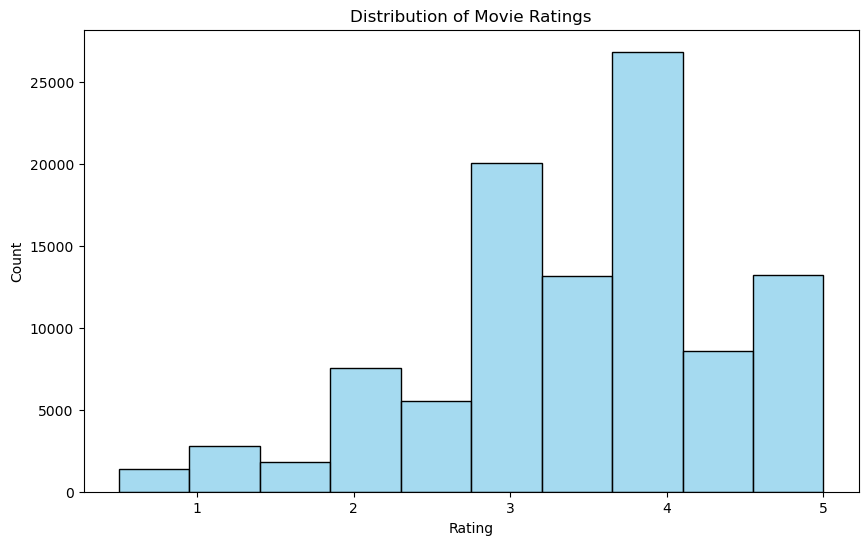

C:\Users\LAPPYFY\AppData\Local\Temp\ipykernel_7100\3942934461.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='average_rating', y='title', data=top_movies.head(10), palette='viridis')


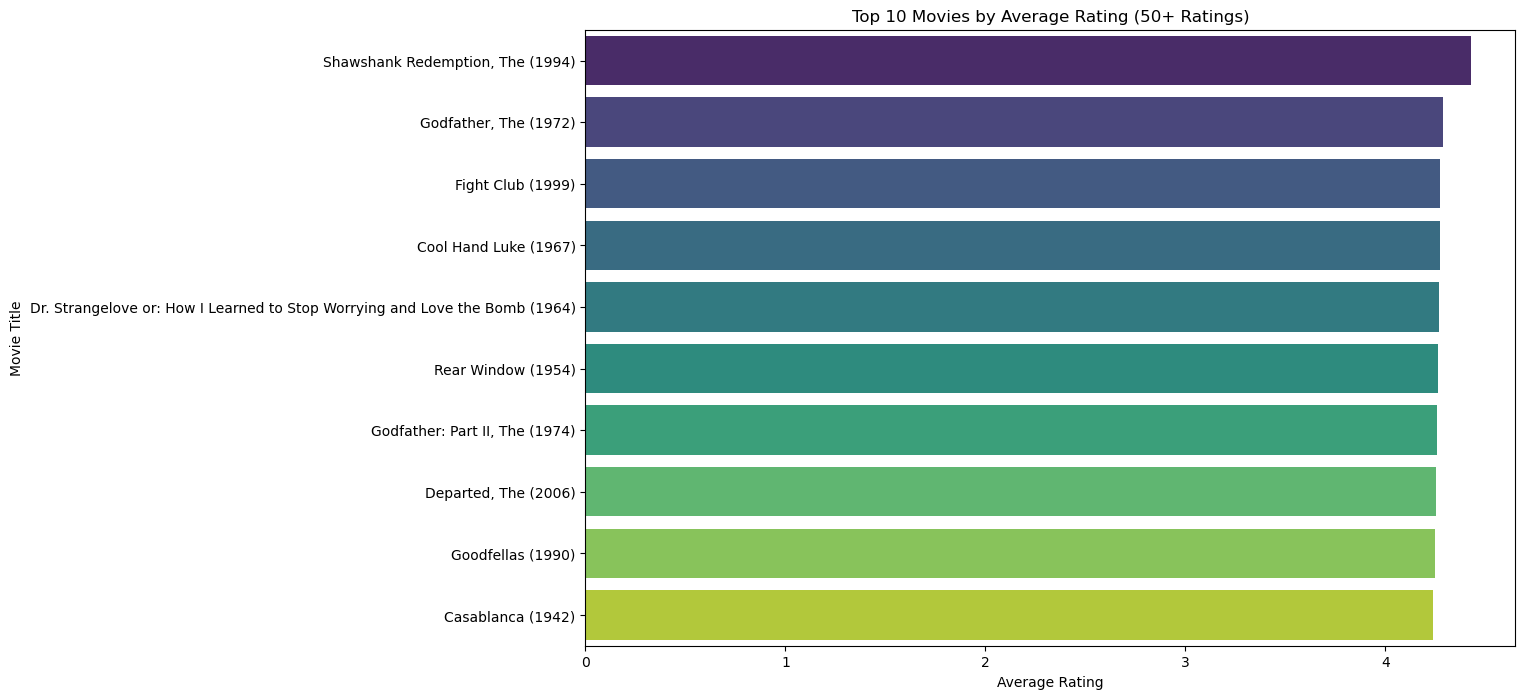

C:\Users\LAPPYFY\AppData\Local\Temp\ipykernel_7100\3942934461.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='num_ratings', y='title', data=most_rated.head(10), palette='magma')


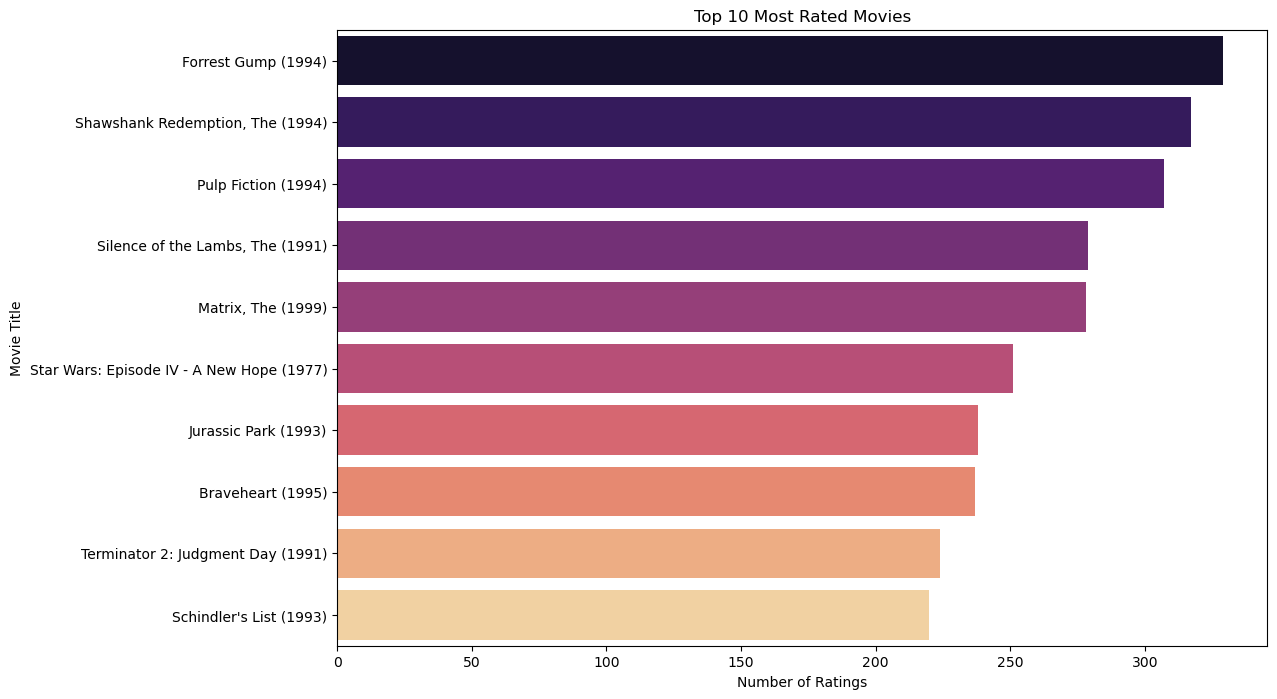

In [ ]:



# Data Visualization: Explore Movie Ratings


import matplotlib.pyplot as plt
import seaborn as sns

# Group the dataset by movie title
movie_ratings = ratings_df.groupby('title').agg({
    'rating': ['mean', 'count']  # Calculate average rating and number of ratings per movie
})

# Rename columns for clarity
movie_ratings.columns = ['average_rating', 'num_ratings']
movie_ratings = movie_ratings.reset_index()

# Display top 5 movies by average rating (with at least 50 ratings)
top_movies = movie_ratings[movie_ratings['num_ratings'] >= 50].sort_values('average_rating', ascending=False)
print("Top 5 movies by average rating (50+ ratings):")
print(top_movies.head())


# Visualization 1: Distribution of Ratings

plt.figure(figsize=(10,6))
sns.histplot(ratings_df['rating'], bins=10, kde=False, color='skyblue')
plt.title('Distribution of Movie Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()


# Visualization 2: Top Movies by Average Rating

plt.figure(figsize=(12,8))
sns.barplot(x='average_rating', y='title', data=top_movies.head(10), palette='viridis')
plt.title('Top 10 Movies by Average Rating (50+ Ratings)')
plt.xlabel('Average Rating')
plt.ylabel('Movie Title')
plt.show()


# Visualization 3: Most Rated Movies

most_rated = movie_ratings.sort_values('num_ratings', ascending=False)
plt.figure(figsize=(12,8))
sns.barplot(x='num_ratings', y='title', data=most_rated.head(10), palette='magma')
plt.title('Top 10 Most Rated Movies')
plt.xlabel('Number of Ratings')
plt.ylabel('Movie Title')
plt.show()

In [9]:
# -----------------------------
# Analyze Movies with Highest Number of Ratings
# -----------------------------

# Sort movies by number of ratings in descending order
most_rated_movies = movie_ratings.sort_values('num_ratings', ascending=False)

# Get the top 5 movies with the highest number of ratings
top_5_most_rated = most_rated_movies.head(5)

# Display their titles, number of ratings, and average ratings
print("Top 5 Most Rated Movies and their Average Ratings:")
print(top_5_most_rated[['title', 'num_ratings', 'average_rating']])

Top 5 Most Rated Movies and their Average Ratings:
                                 title  num_ratings  average_rating
3158               Forrest Gump (1994)          329        4.164134
7593  Shawshank Redemption, The (1994)          317        4.429022
6865               Pulp Fiction (1994)          307        4.197068
7680  Silence of the Lambs, The (1991)          279        4.161290
5512                Matrix, The (1999)          278        4.192446


In [ ]:

# Step 1 for Item-Based CF: Create User-Item Matrix

# Pivot the dataframe so that rows are users, columns are movies, and values are ratings
item_based_matrix = ratings_df.pivot_table(index='userId', columns='movieId', values='rating').fillna(0)

# Display the shape and first few rows
print(f"Item-Based User-Item Matrix shape: {item_based_matrix.shape}")
print("Sample of the matrix:")
print(item_based_matrix.head())

Item-Based User-Item Matrix shape: (610, 9724)
Sample of the matrix:
movieId  1       2       3       4       5       6       7       8       \
userId                                                                    
1           4.0     0.0     4.0     0.0     0.0     4.0     0.0     0.0   
2           0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
3           0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
4           0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
5           4.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

movieId  9       10      ...  193565  193567  193571  193573  193579  193581  \
userId                   ...                                                   
1           0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   
2           0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   
3           0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   
4    

In [ ]:

# Item-Based CF: Recommendations Based on a Single Movie

# Choose a movie for recommendation
movie_name = "Pulp Fiction (1994)"

# Get the movieId for "Pulp Fiction"
pulp_fiction_id = movies[movies['title'] == movie_name]['movieId'].values[0]

# Extract the user ratings for this movie
pulp_fiction_ratings = item_based_matrix[pulp_fiction_id]

print(f"User ratings for '{movie_name}':")
print(pulp_fiction_ratings.head())

User ratings for 'Pulp Fiction (1994)':
userId
1    3.0
2    0.0
3    0.0
4    1.0
5    5.0
Name: 296, dtype: float64


In [12]:
# Short code: Correlation with 'Pulp Fiction'
movie_name = "Pulp Fiction (1994)"
pulp_id = movies[movies['title'] == movie_name]['movieId'].values[0]

# Compute correlations with all movies
corrs = item_based_matrix.corrwith(item_based_matrix[pulp_id]).dropna()

# Sort and show top 10 most similar movies
top_10 = corrs.sort_values(ascending=False).drop(pulp_id).head(10)
print("Top 10 movies similar to Pulp Fiction:")
print(movies[movies['movieId'].isin(top_10.index)]['title'].values)

Top 10 movies similar to Pulp Fiction:
['Seven (a.k.a. Se7en) (1995)' 'Usual Suspects, The (1995)'
 'Shawshank Redemption, The (1994)' 'Forrest Gump (1994)'
 'Silence of the Lambs, The (1991)' 'Fargo (1996)' 'Trainspotting (1996)'
 'Reservoir Dogs (1992)' 'Goodfellas (1990)' 'American History X (1998)']


In [ ]:

# Item-Based CF: Correlation + Rating Counts

# Compute correlation with 'Pulp Fiction'
movie_name = "Pulp Fiction (1994)"
pulp_id = movies[movies['title'] == movie_name]['movieId'].values[0]
corrs = item_based_matrix.corrwith(item_based_matrix[pulp_id]).dropna()
corrs_df = pd.DataFrame(corrs, columns=['correlation'])

# Compute number of ratings per movie
ratings_count = ratings_df.groupby('movieId')['rating'].count().reset_index()
ratings_count.columns = ['movieId', 'num_ratings']

# Merge correlation with rating counts
corrs_df = corrs_df.merge(ratings_count, left_index=True, right_on='movieId')

# Filter movies with at least 50 ratings
recommended = corrs_df[corrs_df['num_ratings'] >= 50].sort_values('correlation', ascending=False)

# Drop the movie itself
recommended = recommended[recommended['movieId'] != pulp_id]

# Show top 10 recommended movies
top_10_movies = recommended.head(10)
print("Top 10 recommended movies (correlation + rating counts):")
print(movies[movies['movieId'].isin(top_10_movies['movieId'])]['title'].values)

Top 10 recommended movies (correlation + rating counts):
['Seven (a.k.a. Se7en) (1995)' 'Usual Suspects, The (1995)'
 'Shawshank Redemption, The (1994)' 'Forrest Gump (1994)'
 'Silence of the Lambs, The (1991)' 'Fargo (1996)' 'Trainspotting (1996)'
 'Reservoir Dogs (1992)' 'Goodfellas (1990)' 'American History X (1998)']


In [14]:
# Remove movies with null correlation
pf_corr = item_based_matrix.corrwith(item_based_matrix[pulp_id])

# Drop NaN correlation values
pf_corr_clean = pf_corr.dropna()

# Convert to DataFrame (optional for easier viewing)
pf_corr_clean = pd.DataFrame(pf_corr_clean, columns=['pf_corr'])

print("Movies after removing NaN correlations:")
print(pf_corr_clean.head())

Movies after removing NaN correlations:
          pf_corr
movieId          
1        0.197743
2        0.158462
3        0.062342
4        0.058673
5        0.050791


In [15]:
# Correlation with Pulp Fiction
pf_corr = item_based_matrix.corrwith(item_based_matrix[pulp_id]).dropna()
pf_corr = pd.DataFrame(pf_corr, columns=['pf_corr'])

# Count number of ratings per movie
rating_counts = ratings_df.groupby('movieId')['rating'].count()
rating_counts = pd.DataFrame(rating_counts)
rating_counts.columns = ['num_ratings']

# Combine correlation and rating counts
pf_corr = pf_corr.merge(rating_counts, left_index=True, right_index=True)

# Filter movies with at least 50 ratings
pf_corr_filtered = pf_corr[pf_corr['num_ratings'] >= 50]

# Sort by highest correlation
top_recommendations = pf_corr_filtered.sort_values('pf_corr', ascending=False)

# Remove Pulp Fiction itself
top_recommendations = top_recommendations.drop(pulp_id)

# Show top 10 recommended movies
top_movie_ids = top_recommendations.head(10).index
recommended_titles = movies[movies['movieId'].isin(top_movie_ids)]['title']

print("Top recommended movies based on Pulp Fiction:")
print(recommended_titles.values)

Top recommended movies based on Pulp Fiction:
['Seven (a.k.a. Se7en) (1995)' 'Usual Suspects, The (1995)'
 'Shawshank Redemption, The (1994)' 'Forrest Gump (1994)'
 'Silence of the Lambs, The (1991)' 'Fargo (1996)' 'Trainspotting (1996)'
 'Reservoir Dogs (1992)' 'Goodfellas (1990)' 'American History X (1998)']
